c:\Users\yahya\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
c:\Users\yahya\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
c:\Users\yahya\anaconda3\Lib\site-packages\pyspark\sql\pandas\types.py:563: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
c:\Users\yahya\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_

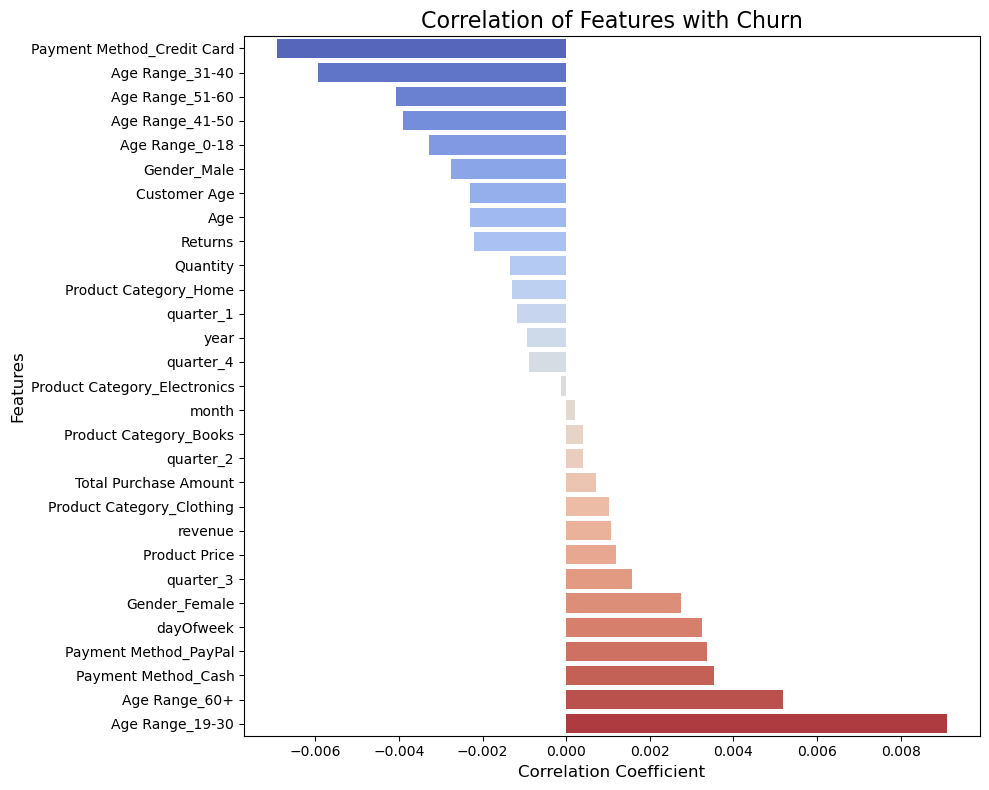

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, year, month, dayofweek, lit
from pyspark.sql.types import IntegerType, DoubleType
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("PySpark Example") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("./originalDataSets/ecommerce_customer_data_large.csv", header=True, inferSchema=True)

# Fill null values with 0
df = df.fillna(0)

# Convert 'Purchase Date' to timestamp
df = df.withColumn("Purchase Date", col("Purchase Date").cast("timestamp"))

# Extract date components
df = df.withColumn("year", year(col("Purchase Date"))) \
       .withColumn("month", month(col("Purchase Date"))) \
       .withColumn("dayOfweek", dayofweek(col("Purchase Date")))\
       .withColumn("quarter", lit(1 + ((month(col("Purchase Date")) - 1) / 3).cast(IntegerType())))

# Create age ranges
df = df.withColumn("Age Range", when(col("Age") <= 18, "0-18")
                   .when((col("Age") > 18) & (col("Age") <= 30), "19-30")
                   .when((col("Age") > 30) & (col("Age") <= 40), "31-40")
                   .when((col("Age") > 40) & (col("Age") <= 50), "41-50")
                   .when((col("Age") > 50) & (col("Age") <= 60), "51-60")
                   .otherwise("60+"))

# Calculate revenue
df = df.withColumn("revenue", col("Product Price") * col("Quantity"))

# Convert to Pandas DataFrame for one-hot encoding and correlation
df_pandas = df.toPandas()

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_pandas, columns=['Payment Method', 'Product Category', 'Gender', 'Age Range', 'quarter'])

# Specify numeric columns for correlation
numeric_columns = ['Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age', 'Returns', 'Age', 
                   'Churn', 'year', 'month', 'dayOfweek', 'revenue']
numeric_columns += [col for col in df_encoded.columns if col.startswith('Payment Method_') 
                    or col.startswith('Product Category_') 
                    or col.startswith('Gender_')
                    or col.startswith('Age Range_')
                    or col.startswith('quarter_')]

# Compute correlation matrix
correlation_matrix = df_encoded[numeric_columns].corr()

# Sort by correlation with 'Churn'
churn_correlation = correlation_matrix['Churn'].sort_values(ascending=False)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Convert correlation dictionary into a Pandas Series
churn_corr_series = pd.Series(churn_correlation[1:])

# Sort for visualization
churn_corr_series = churn_corr_series.sort_values()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Plot horizontal barplot
sns.barplot(x=churn_corr_series.values, y=churn_corr_series.index, palette='coolwarm')

# Add labels and title
plt.title('Correlation of Features with Churn', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


Age bracket distribution

+---------+-----+----------+
|Age Range|count|Percentage|
+---------+-----+----------+
|      60+|47014|      18.8|
|    19-30|58225|      23.3|
|     0-18| 4788|       1.9|
|    41-50|46915|      18.8|
|    31-40|46811|      18.7|
|    51-60|46247|      18.5|
+---------+-----+----------+



c:\Users\yahya\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
c:\Users\yahya\anaconda3\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):


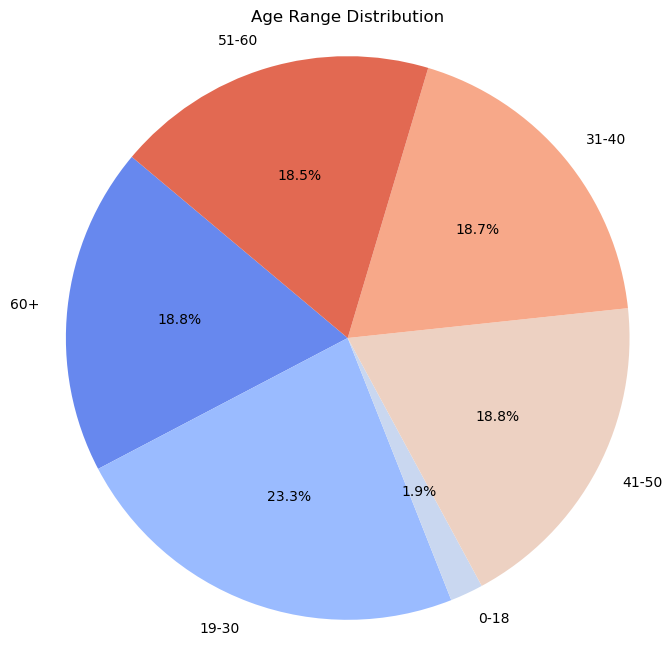

In [84]:
# Group by Age Range and count
age_range_count = df.groupBy("Age Range").count()

# Calculate percentage
total_count = df.count()
age_range_percentage = age_range_percentage.withColumn("Percentage", col("Percentage").cast(DoubleType()).alias("Percentage").cast("decimal(4,1)"))

# Show the result
age_range_percentage.show()

# Convert to Pandas DataFrame for plotting
age_range_percentage_pd = age_range_percentage.toPandas()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(age_range_percentage_pd['Percentage'], labels=age_range_percentage_pd['Age Range'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('coolwarm', len(age_range_percentage_pd)))
plt.title('Age Range Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()